# Libraries

In [46]:
!pip install pyro-ppl normflows

In [59]:
!git clone https://github.com/svsamsonov/Practical_task
!mv Practical_task/* .
!rm -r Practical_task

Cloning into 'Practical_task'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 69.74 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [63]:
import pyro
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.distributions import Normal
from torch.distributions import MultivariateNormal as MNormal
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from typing import Optional, List, Tuple, Iterable, Callable, Union
from torch.distributions import Normal, Categorical
from tqdm.notebook import tqdm, trange
from torch import optim
from torch.nn import KLDivLoss
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
import normflows as nf
from torch.optim.lr_scheduler import StepLR
from distributions import (
    Banana,
    Distribution,
    Funnel,
    IndependentNormal
)

# Distributions

In [67]:
torch.manual_seed(926)


class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
    """
    def __init__(self, num_dims=2):
        self.num_dims = num_dims
        self.normal_first = Normal(0, 1)

    @property
    def dim(self) -> int:
        return self.num_dims

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_last = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., 0] / 2.))
        return normal_last.log_prob(x[..., 1:].permute(-1, *range(x.ndim-1))).sum(0) + self.normal_first.log_prob(x[..., 0])

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Funnel distribution using log p(x)
        """
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        ax.contour(Y, X, Z.exp(),
                   levels=3,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=10000):
        """
        Visualizes Funnel distribution using sampled points
        """
        # Generate points from funnel distribution
        points = np.transpose(self.sample(s))
        Y = points[0]
        X = points[1]

        # Calculate the point density
        XY = np.vstack([X,Y])
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Sample from the Funnel distribution
        """
        all_c = torch.randn((num_samples, self.dim))
        all_c[:, 0] = all_c[:, 0] * 1**0.5
        all_c[:, 1:] = all_c[:, 1:]*(torch.exp(1*all_c[:, 0]))[:, None]
        return all_c

    def estimate_dist(self, s=100000):
        """
        Estimates mean and standard deviation of the Funnel distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]


class Banana:

    def __init__(self, b=0.02, dim=2, sigma=10):
        self.b = b
        self.dim = dim
        self.sigma = sigma

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5 * (x[..., odd] - self.b * x[..., even]**2 + (self.sigma**2) * self.b)**2 - ((x[..., even])**2)/(2 * self.sigma**2)
        return ll.sum(-1)

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def sample(self, s):
        """
        Sample from the Banana distribution
        """
        torch.manual_seed(926)
        even = np.arange(0, self.dim, 2)
        odd = np.arange(1, self.dim, 2)
        var = torch.ones(self.dim)
        var[..., even] = self.sigma**2
        base_dist = D.MultivariateNormal(torch.zeros(self.dim), torch.diag(var))
        samples = base_dist.sample((s,))
        samples[..., odd] += self.b * samples[..., even]**2 - self.b * self.sigma**2
        return samples

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Banana distribution using log p(x)
        """
        x = np.linspace(-20, 20, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        ax.contour(X, Y, Z.exp(),
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=1000):
        """
        Visualizes Banana distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def estimate_dist(self, s=10000000):
        """
        Estimates mean and standard deviation of the Banana distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]


class MyDistribution(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def grad_log(self, x: torch.Tensor):
        """
        Calculates gradient of log density for given points
        Expects log_prob function to be working in differentiable manner
        :param x: [n_batch, dimension]
        :return: gradients [n_batch, dimension]
        """
        grads = []
        x.requires_grad = True
        for val in x:
            val = val.reshape(1, -1)
            out = self.log_prob(val)
            grad = torch.autograd.grad(out, val)
            grads.append(grad[0].squeeze(0))
        x.requires_grad = False
        return torch.stack(grads, dim=0)


class GMM(MyDistribution):
    def __init__(self, dim, mu, sigma, rho=0.5):
        super().__init__(dim)
        cov_mat = torch.eye(dim) * sigma
        mu_mat = torch.ones((2, dim))*mu
        mu_mat[1, :] = -mu_mat[1, :]
        cov_mat = torch.tile(cov_mat.unsqueeze(0), (2, 1, 1))
        mix = D.Categorical(torch.tensor([rho, 1-rho]))
        comp = D.MultivariateNormal(
            mu_mat, cov_mat)
        self.gmm = D.MixtureSameFamily(mix, comp)

    def log_prob(self, x):
        return self.gmm.log_prob(x)

    def sample(self, n):
        return self.gmm.sample((n,))

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Banana distribution using log p(x)
        """
        x = np.linspace(-20, 20, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        ax.contour(X, Y, Z.exp(),
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=1000):
        """
        Visualizes Banana distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()


class Cauchy(Distribution):
    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.loc = kwargs.get("loc")
        self.scale = kwargs.get("scale")
        self.dim = kwargs.get("dim")
        self.distr = torch.distributions.Cauchy(self.loc, self.scale)

    def log_prob(self, z, x=None):
        log_target = self.distr.log_prob(z).sum(-1)
        return log_target

    def sample(self, n=1):
        return self.distr.sample(torch.cat([torch.empty(n)], -1).shape)

# Basic Sampler (I-SIR)

In [52]:
torch.manual_seed(926)

def ISIR(start: torch.FloatTensor,
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *,
        n_particles: int,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)


    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()

        x = particles[np.arange(x.shape[0]), indices]
        logp_x = logps[np.arange(x.shape[0]), indices]
        logq_x = logqs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

# HMC

In [53]:
def HMC(
    start,
    target,
    n_samples: int,
    burn_in: int,
    *,
    step_size: float,
    num_leapfrog_steps: float = 1,
    verbose: bool = False,
) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates
        for each iteration
    """
    x = start.clone()
    x.requires_grad_(False)

    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy,
        step_size=step_size,
        num_steps=num_leapfrog_steps,
        full_mass=False,
    )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

# Testing sampler

In [54]:
def experiment_ISIR(ran, gmms, ds, sigmas):
  for i in ran:
    proposal = Cauchy(
        dim=ds[i],
        loc=torch.zeros(ds[i]).to(device),
        scale= 1.,
        device="cpu",
    )
    start_gmm = proposal.sample((N_CHAINS,)).detach().cpu()
    chains, acceptance_rates_isir = ISIR(start_gmm, gmms[i], proposal, N_SAMPLES, BURN_IN, n_particles=1000, verbose=True)

In [55]:
def experiment_HMC(ran, gmms, ds, sigmas):
  for i in ran:
    proposal = Cauchy(
        dim=ds[i],
        loc=torch.zeros(ds[i]).to(device),
        scale= 1.,
        device="cpu",
    )
    start_gmm = proposal.sample((N_CHAINS,)).detach().cpu()
    chains= HMC(start_gmm, proposal, N_SAMPLES, BURN_IN, step_size = 0.1, verbose=True)

In [56]:
a = 1
d_ = [2, 10, 50, 100]
sigma_ = [0.1, 1, 3]

gmms, ds, sigmas = [], [], []

for d in d_:
  for sigma in sigma_:
    gmm = GMM(dim=d, mu=1, sigma=sigma)
    gmms.append(gmm)
    ds.append(d)
    sigmas.append(sigma)

In [57]:
N_CHAINS = 50
N_SAMPLES = 1000
BURN_IN = 10**2
device="cpu"

experiment_ISIR(range(0,1), gmms, ds, sigmas)

  0%|          | 0/1100 [00:00<?, ?it/s]

In [58]:
experiment_HMC(range(0,1), gmms, ds, sigmas)

Sample: 100%|██████████| 1100/1100 [00:01, 659.55it/s, step size=3.53e-01, acc. prob=0.733]


# Training parameters

In [69]:
dim = 2
target = Banana(dim=dim, b=0.02)

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

proposal = GMM(dim=dim, sigma=scale, mu=loc)

N_CHAINS = torch.tensor(50)
N_SAMPLES = 100
BURN_IN = 10
device="cpu"

#criterion = KLDivLoss(log_target=True)
optimizer = optim.Adam(lr=1e-1, params=(loc, scale))

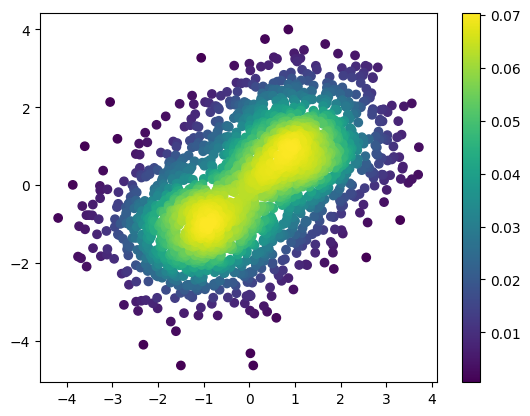

In [71]:
proposal.visualize_dist(2000)

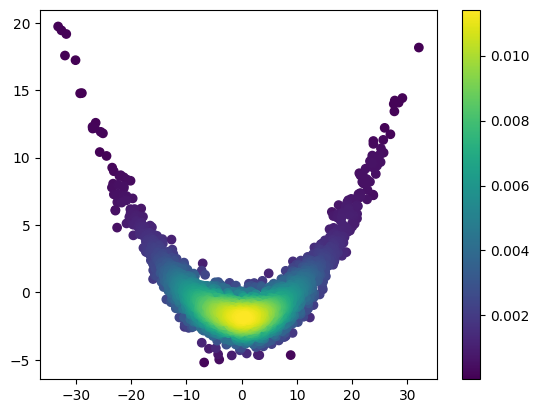

In [72]:
target.visualize_dist(2000)

In [73]:
n_iter = 200
loss_arr = []

scheduler = StepLR(optimizer, 1, gamma=1-1e-2)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)
    if i%10:
      print(scale, loc)
    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.01,
                  num_leapfrog_steps = 5,
                  verbose = False,
                )
    #log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])

  0%|          | 0/200 [00:00<?, ?it/s]

Sample: 100%|██████████| 110/110 [00:00, 472.11it/s, step size=6.42e-01, acc. prob=0.826]


Parameter containing:
tensor([1.1000, 1.1000], requires_grad=True) Parameter containing:
tensor([1.1000, 0.9000], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 497.80it/s, step size=6.26e-01, acc. prob=0.797]


Parameter containing:
tensor([1.1983, 1.1990], requires_grad=True) Parameter containing:
tensor([1.1987, 0.8015], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 498.69it/s, step size=5.81e-01, acc. prob=0.870]


Parameter containing:
tensor([1.2923, 1.2956], requires_grad=True) Parameter containing:
tensor([1.2955, 0.7086], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 501.64it/s, step size=6.42e-01, acc. prob=0.798]


Parameter containing:
tensor([1.3832, 1.3890], requires_grad=True) Parameter containing:
tensor([1.3906, 0.6187], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 538.47it/s, step size=6.32e-01, acc. prob=0.813]


Parameter containing:
tensor([1.4721, 1.4802], requires_grad=True) Parameter containing:
tensor([1.4843, 0.5274], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 566.15it/s, step size=4.33e-01, acc. prob=0.944]


Parameter containing:
tensor([1.5537, 1.5688], requires_grad=True) Parameter containing:
tensor([1.5731, 0.4363], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 504.55it/s, step size=6.42e-01, acc. prob=0.824]


Parameter containing:
tensor([1.6336, 1.6541], requires_grad=True) Parameter containing:
tensor([1.6618, 0.3445], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 478.87it/s, step size=5.81e-01, acc. prob=0.863]


Parameter containing:
tensor([1.7105, 1.7356], requires_grad=True) Parameter containing:
tensor([1.7479, 0.2589], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 578.86it/s, step size=4.39e-01, acc. prob=0.936]


Parameter containing:
tensor([1.7832, 1.8134], requires_grad=True) Parameter containing:
tensor([1.8313, 0.1784], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 594.00it/s, step size=6.40e-01, acc. prob=0.784]


Parameter containing:
tensor([1.9180, 1.9585], requires_grad=True) Parameter containing:
tensor([1.9914, 0.0734], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 602.45it/s, step size=6.37e-01, acc. prob=0.801]


Parameter containing:
tensor([1.9828, 2.0265], requires_grad=True) Parameter containing:
tensor([2.0692, 0.0303], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 590.98it/s, step size=6.42e-01, acc. prob=0.763]


Parameter containing:
tensor([2.0431, 2.0914], requires_grad=True) Parameter containing:
tensor([ 2.1427, -0.0053], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 512.39it/s, step size=4.51e-01, acc. prob=0.934]


Parameter containing:
tensor([2.0997, 2.1535], requires_grad=True) Parameter containing:
tensor([ 2.2128, -0.0404], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 590.33it/s, step size=6.10e-01, acc. prob=0.830]


Parameter containing:
tensor([2.1546, 2.2120], requires_grad=True) Parameter containing:
tensor([ 2.2814, -0.0669], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 576.08it/s, step size=6.42e-01, acc. prob=0.821]


Parameter containing:
tensor([2.2081, 2.2666], requires_grad=True) Parameter containing:
tensor([ 2.3490, -0.0897], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 551.83it/s, step size=4.55e-01, acc. prob=0.922]


Parameter containing:
tensor([2.2581, 2.3185], requires_grad=True) Parameter containing:
tensor([ 2.4129, -0.0956], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 535.28it/s, step size=6.29e-01, acc. prob=0.826]


Parameter containing:
tensor([2.3064, 2.3678], requires_grad=True) Parameter containing:
tensor([ 2.4746, -0.0900], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 504.80it/s, step size=6.42e-01, acc. prob=0.825]


Parameter containing:
tensor([2.3530, 2.4146], requires_grad=True) Parameter containing:
tensor([ 2.5356, -0.0857], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 550.02it/s, step size=6.35e-01, acc. prob=0.826]


Parameter containing:
tensor([2.4407, 2.5017], requires_grad=True) Parameter containing:
tensor([ 2.6505, -0.0824], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 549.58it/s, step size=6.04e-01, acc. prob=0.853]


Parameter containing:
tensor([2.4816, 2.5415], requires_grad=True) Parameter containing:
tensor([ 2.7057, -0.0817], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 481.88it/s, step size=6.03e-01, acc. prob=0.862]


Parameter containing:
tensor([2.5230, 2.5789], requires_grad=True) Parameter containing:
tensor([ 2.7621, -0.0761], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 574.27it/s, step size=4.39e-01, acc. prob=0.939]


Parameter containing:
tensor([2.5613, 2.6141], requires_grad=True) Parameter containing:
tensor([ 2.8141, -0.0613], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 557.58it/s, step size=4.38e-01, acc. prob=0.941]


Parameter containing:
tensor([2.5973, 2.6472], requires_grad=True) Parameter containing:
tensor([ 2.8637, -0.0502], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 549.24it/s, step size=4.22e-01, acc. prob=0.948]


Parameter containing:
tensor([2.6311, 2.6789], requires_grad=True) Parameter containing:
tensor([ 2.9103, -0.0366], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 534.81it/s, step size=6.42e-01, acc. prob=0.796]


Parameter containing:
tensor([2.6635, 2.7087], requires_grad=True) Parameter containing:
tensor([ 2.9549, -0.0227], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 626.83it/s, step size=6.37e-01, acc. prob=0.808]


Parameter containing:
tensor([2.6942, 2.7368], requires_grad=True) Parameter containing:
tensor([ 2.9979, -0.0075], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 584.71it/s, step size=6.42e-01, acc. prob=0.796]


Parameter containing:
tensor([2.7247, 2.7629], requires_grad=True) Parameter containing:
tensor([3.0411, 0.0049], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 415.78it/s, step size=5.86e-01, acc. prob=0.848]


Parameter containing:
tensor([2.7831, 2.8116], requires_grad=True) Parameter containing:
tensor([3.1236, 0.0321], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 434.10it/s, step size=6.38e-01, acc. prob=0.780]


Parameter containing:
tensor([2.8100, 2.8346], requires_grad=True) Parameter containing:
tensor([3.1609, 0.0469], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 472.51it/s, step size=4.35e-01, acc. prob=0.947]


Parameter containing:
tensor([2.8356, 2.8563], requires_grad=True) Parameter containing:
tensor([3.1970, 0.0638], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 456.19it/s, step size=6.28e-01, acc. prob=0.811]


Parameter containing:
tensor([2.8608, 2.8767], requires_grad=True) Parameter containing:
tensor([3.2327, 0.0781], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 443.87it/s, step size=6.38e-01, acc. prob=0.803]


Parameter containing:
tensor([2.8860, 2.8955], requires_grad=True) Parameter containing:
tensor([3.2687, 0.0919], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 482.76it/s, step size=4.84e-01, acc. prob=0.922]


Parameter containing:
tensor([2.9104, 2.9132], requires_grad=True) Parameter containing:
tensor([3.3047, 0.1065], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 414.19it/s, step size=4.38e-01, acc. prob=0.937]


Parameter containing:
tensor([2.9337, 2.9297], requires_grad=True) Parameter containing:
tensor([3.3387, 0.1204], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 392.75it/s, step size=6.41e-01, acc. prob=0.809]


Parameter containing:
tensor([2.9565, 2.9456], requires_grad=True) Parameter containing:
tensor([3.3712, 0.1353], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 418.43it/s, step size=6.42e-01, acc. prob=0.840]


Parameter containing:
tensor([2.9792, 2.9614], requires_grad=True) Parameter containing:
tensor([3.4025, 0.1424], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 383.59it/s, step size=6.42e-01, acc. prob=0.831]


Parameter containing:
tensor([3.0224, 2.9899], requires_grad=True) Parameter containing:
tensor([3.4638, 0.1594], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 414.72it/s, step size=6.41e-01, acc. prob=0.805]


Parameter containing:
tensor([3.0424, 3.0033], requires_grad=True) Parameter containing:
tensor([3.4917, 0.1594], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 501.51it/s, step size=6.17e-01, acc. prob=0.816]


Parameter containing:
tensor([3.0628, 3.0169], requires_grad=True) Parameter containing:
tensor([3.5192, 0.1516], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 437.57it/s, step size=6.42e-01, acc. prob=0.798]


Parameter containing:
tensor([3.0823, 3.0298], requires_grad=True) Parameter containing:
tensor([3.5461, 0.1428], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 501.87it/s, step size=6.42e-01, acc. prob=0.802]


Parameter containing:
tensor([3.1017, 3.0418], requires_grad=True) Parameter containing:
tensor([3.5735, 0.1325], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 516.42it/s, step size=6.41e-01, acc. prob=0.823]


Parameter containing:
tensor([3.1205, 3.0534], requires_grad=True) Parameter containing:
tensor([3.5996, 0.1257], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 541.38it/s, step size=6.42e-01, acc. prob=0.816]


Parameter containing:
tensor([3.1390, 3.0645], requires_grad=True) Parameter containing:
tensor([3.6249, 0.1199], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 507.02it/s, step size=6.35e-01, acc. prob=0.812]


Parameter containing:
tensor([3.1571, 3.0751], requires_grad=True) Parameter containing:
tensor([3.6502, 0.1095], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 572.49it/s, step size=6.12e-01, acc. prob=0.855]


Parameter containing:
tensor([3.1746, 3.0854], requires_grad=True) Parameter containing:
tensor([3.6745, 0.0984], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 496.26it/s, step size=5.06e-01, acc. prob=0.907]


Parameter containing:
tensor([3.2086, 3.1055], requires_grad=True) Parameter containing:
tensor([3.7187, 0.0645], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 507.40it/s, step size=6.31e-01, acc. prob=0.843]


Parameter containing:
tensor([3.2257, 3.1153], requires_grad=True) Parameter containing:
tensor([3.7396, 0.0459], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 534.86it/s, step size=4.98e-01, acc. prob=0.910]


Parameter containing:
tensor([3.2425, 3.1247], requires_grad=True) Parameter containing:
tensor([3.7598, 0.0288], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 517.85it/s, step size=6.29e-01, acc. prob=0.813]


Parameter containing:
tensor([3.2589, 3.1332], requires_grad=True) Parameter containing:
tensor([3.7796, 0.0102], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 531.70it/s, step size=6.42e-01, acc. prob=0.811]


Parameter containing:
tensor([3.2749, 3.1413], requires_grad=True) Parameter containing:
tensor([ 3.7995e+00, -2.7568e-03], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 496.34it/s, step size=4.34e-01, acc. prob=0.940]


Parameter containing:
tensor([3.2906, 3.1489], requires_grad=True) Parameter containing:
tensor([ 3.8192, -0.0175], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 436.98it/s, step size=6.39e-01, acc. prob=0.798]


Parameter containing:
tensor([3.3058, 3.1559], requires_grad=True) Parameter containing:
tensor([ 3.8383, -0.0301], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 467.53it/s, step size=6.30e-01, acc. prob=0.788]


Parameter containing:
tensor([3.3211, 3.1630], requires_grad=True) Parameter containing:
tensor([ 3.8566, -0.0386], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 526.59it/s, step size=6.24e-01, acc. prob=0.796]


Parameter containing:
tensor([3.3362, 3.1698], requires_grad=True) Parameter containing:
tensor([ 3.8748, -0.0483], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 504.46it/s, step size=6.40e-01, acc. prob=0.801]


Parameter containing:
tensor([3.3660, 3.1827], requires_grad=True) Parameter containing:
tensor([ 3.9113, -0.0589], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 575.95it/s, step size=6.42e-01, acc. prob=0.777]


Parameter containing:
tensor([3.3811, 3.1885], requires_grad=True) Parameter containing:
tensor([ 3.9298, -0.0612], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 595.15it/s, step size=6.42e-01, acc. prob=0.800]


Parameter containing:
tensor([3.3960, 3.1941], requires_grad=True) Parameter containing:
tensor([ 3.9485, -0.0637], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 562.94it/s, step size=9.71e-01, acc. prob=0.437]


Parameter containing:
tensor([3.4108, 3.1995], requires_grad=True) Parameter containing:
tensor([ 3.9671, -0.0629], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 534.23it/s, step size=6.39e-01, acc. prob=0.832]


Parameter containing:
tensor([3.4253, 3.2047], requires_grad=True) Parameter containing:
tensor([ 3.9856, -0.0671], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 500.78it/s, step size=4.15e-01, acc. prob=0.945]


Parameter containing:
tensor([3.4387, 3.2100], requires_grad=True) Parameter containing:
tensor([ 4.0025, -0.0738], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 521.70it/s, step size=6.42e-01, acc. prob=0.776]


Parameter containing:
tensor([3.4524, 3.2149], requires_grad=True) Parameter containing:
tensor([ 4.0200, -0.0797], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 584.74it/s, step size=5.43e-01, acc. prob=0.878]


Parameter containing:
tensor([3.4661, 3.2198], requires_grad=True) Parameter containing:
tensor([ 4.0366, -0.0869], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 513.15it/s, step size=6.27e-01, acc. prob=0.819]


Parameter containing:
tensor([3.4800, 3.2241], requires_grad=True) Parameter containing:
tensor([ 4.0551, -0.0952], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 599.93it/s, step size=6.42e-01, acc. prob=0.844]


Parameter containing:
tensor([3.5071, 3.2325], requires_grad=True) Parameter containing:
tensor([ 4.0916, -0.1020], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 618.29it/s, step size=4.82e-01, acc. prob=0.921]


Parameter containing:
tensor([3.5199, 3.2361], requires_grad=True) Parameter containing:
tensor([ 4.1090, -0.1039], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 520.90it/s, step size=6.36e-01, acc. prob=0.825]


Parameter containing:
tensor([3.5329, 3.2397], requires_grad=True) Parameter containing:
tensor([ 4.1262, -0.1084], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 590.91it/s, step size=4.49e-01, acc. prob=0.931]

Parameter containing:
tensor([3.5454, 3.2427], requires_grad=True)

 Parameter containing:
tensor([ 4.1432, -0.1066], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 580.85it/s, step size=6.24e-01, acc. prob=0.830]


Parameter containing:
tensor([3.5580, 3.2454], requires_grad=True) Parameter containing:
tensor([ 4.1603, -0.1011], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 559.93it/s, step size=6.32e-01, acc. prob=0.805]


Parameter containing:
tensor([3.5705, 3.2477], requires_grad=True) Parameter containing:
tensor([ 4.1779, -0.0971], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 646.46it/s, step size=4.43e-01, acc. prob=0.933]


Parameter containing:
tensor([3.5823, 3.2497], requires_grad=True) Parameter containing:
tensor([ 4.1946, -0.0916], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 581.84it/s, step size=6.42e-01, acc. prob=0.789]


Parameter containing:
tensor([3.5942, 3.2518], requires_grad=True) Parameter containing:
tensor([ 4.2112, -0.0834], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 596.91it/s, step size=6.42e-01, acc. prob=0.825]


Parameter containing:
tensor([3.6057, 3.2539], requires_grad=True) Parameter containing:
tensor([ 4.2263, -0.0711], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 596.42it/s, step size=9.77e-01, acc. prob=0.393]


Parameter containing:
tensor([3.6302, 3.2577], requires_grad=True) Parameter containing:
tensor([ 4.2590, -0.0416], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 589.50it/s, step size=6.42e-01, acc. prob=0.798]


Parameter containing:
tensor([3.6424, 3.2594], requires_grad=True) Parameter containing:
tensor([ 4.2757, -0.0281], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 481.56it/s, step size=6.42e-01, acc. prob=0.811]


Parameter containing:
tensor([3.6544, 3.2607], requires_grad=True) Parameter containing:
tensor([ 4.2923, -0.0174], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 546.70it/s, step size=6.42e-01, acc. prob=0.800]


Parameter containing:
tensor([3.6661, 3.2620], requires_grad=True) Parameter containing:
tensor([ 4.3085, -0.0053], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 381.67it/s, step size=6.26e-01, acc. prob=0.785]


Parameter containing:
tensor([3.6775, 3.2631], requires_grad=True) Parameter containing:
tensor([4.3246, 0.0085], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 337.12it/s, step size=6.34e-01, acc. prob=0.809]


Parameter containing:
tensor([3.6893, 3.2640], requires_grad=True) Parameter containing:
tensor([4.3414, 0.0251], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 319.12it/s, step size=6.29e-01, acc. prob=0.815]


Parameter containing:
tensor([3.7004, 3.2653], requires_grad=True) Parameter containing:
tensor([4.3561, 0.0380], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 321.58it/s, step size=6.42e-01, acc. prob=0.795]


Parameter containing:
tensor([3.7121, 3.2664], requires_grad=True) Parameter containing:
tensor([4.3720, 0.0506], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 394.35it/s, step size=4.65e-01, acc. prob=0.913]


Parameter containing:
tensor([3.7233, 3.2675], requires_grad=True) Parameter containing:
tensor([4.3866, 0.0616], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 378.57it/s, step size=6.41e-01, acc. prob=0.783]


Parameter containing:
tensor([3.7452, 3.2694], requires_grad=True) Parameter containing:
tensor([4.4143, 0.0767], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 383.25it/s, step size=6.42e-01, acc. prob=0.806]


Parameter containing:
tensor([3.7563, 3.2705], requires_grad=True) Parameter containing:
tensor([4.4275, 0.0843], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 394.96it/s, step size=4.38e-01, acc. prob=0.929]


Parameter containing:
tensor([3.7669, 3.2715], requires_grad=True) Parameter containing:
tensor([4.4404, 0.0859], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 387.03it/s, step size=6.06e-01, acc. prob=0.835]


Parameter containing:
tensor([3.7773, 3.2725], requires_grad=True) Parameter containing:
tensor([4.4524, 0.0898], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 389.93it/s, step size=6.42e-01, acc. prob=0.838]


Parameter containing:
tensor([3.7878, 3.2737], requires_grad=True) Parameter containing:
tensor([4.4644, 0.0902], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 447.28it/s, step size=4.32e-01, acc. prob=0.940]


Parameter containing:
tensor([3.7977, 3.2748], requires_grad=True) Parameter containing:
tensor([4.4750, 0.0870], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 559.51it/s, step size=6.37e-01, acc. prob=0.833]


Parameter containing:
tensor([3.8072, 3.2761], requires_grad=True) Parameter containing:
tensor([4.4846, 0.0843], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 610.72it/s, step size=4.47e-01, acc. prob=0.952]


Parameter containing:
tensor([3.8166, 3.2767], requires_grad=True) Parameter containing:
tensor([4.4949, 0.0828], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 530.89it/s, step size=4.65e-01, acc. prob=0.927]


Parameter containing:
tensor([3.8260, 3.2776], requires_grad=True) Parameter containing:
tensor([4.5049, 0.0813], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 603.54it/s, step size=6.42e-01, acc. prob=0.811]


Parameter containing:
tensor([3.8442, 3.2792], requires_grad=True) Parameter containing:
tensor([4.5235, 0.0789], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 571.39it/s, step size=6.02e-01, acc. prob=0.830]


Parameter containing:
tensor([3.8531, 3.2799], requires_grad=True) Parameter containing:
tensor([4.5331, 0.0778], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 596.76it/s, step size=6.00e-01, acc. prob=0.851]


Parameter containing:
tensor([3.8621, 3.2803], requires_grad=True) Parameter containing:
tensor([4.5430, 0.0739], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 578.58it/s, step size=6.16e-01, acc. prob=0.828]


Parameter containing:
tensor([3.8712, 3.2805], requires_grad=True) Parameter containing:
tensor([4.5535, 0.0721], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 578.58it/s, step size=4.34e-01, acc. prob=0.934]


Parameter containing:
tensor([3.8798, 3.2802], requires_grad=True) Parameter containing:
tensor([4.5639, 0.0678], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 486.51it/s, step size=6.42e-01, acc. prob=0.798]


Parameter containing:
tensor([3.8883, 3.2799], requires_grad=True) Parameter containing:
tensor([4.5739, 0.0651], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 602.58it/s, step size=6.32e-01, acc. prob=0.799]


Parameter containing:
tensor([3.8968, 3.2797], requires_grad=True) Parameter containing:
tensor([4.5837, 0.0560], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 598.81it/s, step size=4.80e-01, acc. prob=0.918]


Parameter containing:
tensor([3.9050, 3.2794], requires_grad=True) Parameter containing:
tensor([4.5928, 0.0466], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 563.99it/s, step size=6.42e-01, acc. prob=0.773]


Parameter containing:
tensor([3.9135, 3.2791], requires_grad=True) Parameter containing:
tensor([4.6018, 0.0399], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 558.41it/s, step size=6.29e-01, acc. prob=0.829]


Parameter containing:
tensor([3.9305, 3.2780], requires_grad=True) Parameter containing:
tensor([4.6217, 0.0209], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 581.39it/s, step size=6.38e-01, acc. prob=0.813]


Parameter containing:
tensor([3.9390, 3.2776], requires_grad=True) Parameter containing:
tensor([4.6318, 0.0126], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 593.49it/s, step size=4.41e-01, acc. prob=0.943]


Parameter containing:
tensor([3.9471, 3.2771], requires_grad=True) Parameter containing:
tensor([4.6408e+00, 1.4106e-03], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 512.40it/s, step size=6.42e-01, acc. prob=0.812]


Parameter containing:
tensor([3.9551, 3.2765], requires_grad=True) Parameter containing:
tensor([ 4.6497, -0.0103], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 585.23it/s, step size=6.42e-01, acc. prob=0.820]


Parameter containing:
tensor([3.9629, 3.2762], requires_grad=True) Parameter containing:
tensor([ 4.6573, -0.0209], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 520.46it/s, step size=6.27e-01, acc. prob=0.817]


Parameter containing:
tensor([3.9708, 3.2762], requires_grad=True) Parameter containing:
tensor([ 4.6650, -0.0335], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 566.82it/s, step size=6.40e-01, acc. prob=0.832]


Parameter containing:
tensor([3.9787, 3.2763], requires_grad=True) Parameter containing:
tensor([ 4.6729, -0.0478], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 486.56it/s, step size=6.79e-01, acc. prob=0.761]


Parameter containing:
tensor([3.9862, 3.2763], requires_grad=True) Parameter containing:
tensor([ 4.6807, -0.0620], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 469.99it/s, step size=6.42e-01, acc. prob=0.817]


Parameter containing:
tensor([3.9940, 3.2761], requires_grad=True) Parameter containing:
tensor([ 4.6890, -0.0766], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 594.76it/s, step size=6.04e-01, acc. prob=0.858]


Parameter containing:
tensor([4.0090, 3.2761], requires_grad=True) Parameter containing:
tensor([ 4.7048, -0.0952], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 523.00it/s, step size=4.38e-01, acc. prob=0.934]


Parameter containing:
tensor([4.0162, 3.2760], requires_grad=True) Parameter containing:
tensor([ 4.7126, -0.0978], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 521.66it/s, step size=5.37e-01, acc. prob=0.885]


Parameter containing:
tensor([4.0233, 3.2757], requires_grad=True) Parameter containing:
tensor([ 4.7206, -0.0985], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 473.33it/s, step size=6.38e-01, acc. prob=0.782]


Parameter containing:
tensor([4.0302, 3.2755], requires_grad=True) Parameter containing:
tensor([ 4.7283, -0.0968], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 570.23it/s, step size=6.42e-01, acc. prob=0.802]


Parameter containing:
tensor([4.0375, 3.2756], requires_grad=True) Parameter containing:
tensor([ 4.7363, -0.0925], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 563.09it/s, step size=4.34e-01, acc. prob=0.936]


Parameter containing:
tensor([4.0445, 3.2756], requires_grad=True) Parameter containing:
tensor([ 4.7438, -0.0865], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 601.59it/s, step size=6.42e-01, acc. prob=0.811]


Parameter containing:
tensor([4.0518, 3.2757], requires_grad=True) Parameter containing:
tensor([ 4.7516, -0.0774], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 530.47it/s, step size=4.38e-01, acc. prob=0.938]


Parameter containing:
tensor([4.0587, 3.2757], requires_grad=True) Parameter containing:
tensor([ 4.7592, -0.0688], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 468.75it/s, step size=4.93e-01, acc. prob=0.909]


Parameter containing:
tensor([4.0653, 3.2756], requires_grad=True) Parameter containing:
tensor([ 4.7656, -0.0613], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 514.96it/s, step size=8.25e-01, acc. prob=0.636]


Parameter containing:
tensor([4.0789, 3.2761], requires_grad=True) Parameter containing:
tensor([ 4.7784, -0.0468], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 573.31it/s, step size=6.42e-01, acc. prob=0.786]


Parameter containing:
tensor([4.0861, 3.2767], requires_grad=True) Parameter containing:
tensor([ 4.7860, -0.0417], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 556.76it/s, step size=4.30e-01, acc. prob=0.938]


Parameter containing:
tensor([4.0933, 3.2770], requires_grad=True) Parameter containing:
tensor([ 4.7930, -0.0356], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 580.19it/s, step size=6.42e-01, acc. prob=0.778]


Parameter containing:
tensor([4.1007, 3.2772], requires_grad=True) Parameter containing:
tensor([ 4.8005, -0.0312], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 481.54it/s, step size=5.63e-01, acc. prob=0.839]


Parameter containing:
tensor([4.1078, 3.2773], requires_grad=True) Parameter containing:
tensor([ 4.8082, -0.0284], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 476.23it/s, step size=4.25e-01, acc. prob=0.944]


Parameter containing:
tensor([4.1147, 3.2771], requires_grad=True) Parameter containing:
tensor([ 4.8156, -0.0247], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 492.99it/s, step size=6.42e-01, acc. prob=0.772]


Parameter containing:
tensor([4.1216, 3.2767], requires_grad=True) Parameter containing:
tensor([ 4.8234, -0.0191], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 566.01it/s, step size=6.35e-01, acc. prob=0.783]


Parameter containing:
tensor([4.1285, 3.2763], requires_grad=True) Parameter containing:
tensor([ 4.8316, -0.0140], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 548.76it/s, step size=6.40e-01, acc. prob=0.804]


Parameter containing:
tensor([4.1355, 3.2762], requires_grad=True) Parameter containing:
tensor([ 4.8390, -0.0086], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 403.17it/s, step size=6.20e-01, acc. prob=0.836]


Parameter containing:
tensor([4.1491, 3.2756], requires_grad=True) Parameter containing:
tensor([4.8532e+00, 4.3260e-03], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 448.33it/s, step size=4.30e-01, acc. prob=0.951]


Parameter containing:
tensor([4.1558, 3.2750], requires_grad=True) Parameter containing:
tensor([4.8606, 0.0071], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 419.79it/s, step size=5.78e-01, acc. prob=0.858]


Parameter containing:
tensor([4.1624, 3.2747], requires_grad=True) Parameter containing:
tensor([4.8676, 0.0090], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 424.44it/s, step size=6.39e-01, acc. prob=0.825]


Parameter containing:
tensor([4.1689, 3.2746], requires_grad=True) Parameter containing:
tensor([4.8740, 0.0106], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 425.53it/s, step size=6.37e-01, acc. prob=0.793]


Parameter containing:
tensor([4.1754, 3.2745], requires_grad=True) Parameter containing:
tensor([4.8802, 0.0119], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 399.55it/s, step size=6.03e-01, acc. prob=0.859]


Parameter containing:
tensor([4.1816, 3.2745], requires_grad=True) Parameter containing:
tensor([4.8856, 0.0144], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 302.70it/s, step size=6.42e-01, acc. prob=0.774]


Parameter containing:
tensor([4.1878, 3.2743], requires_grad=True) Parameter containing:
tensor([4.8912, 0.0175], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 341.24it/s, step size=6.33e-01, acc. prob=0.803]


Parameter containing:
tensor([4.1939, 3.2742], requires_grad=True) Parameter containing:
tensor([4.8966, 0.0220], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 297.53it/s, step size=4.75e-01, acc. prob=0.925]


Parameter containing:
tensor([4.1998, 3.2740], requires_grad=True) Parameter containing:
tensor([4.9017, 0.0268], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 309.77it/s, step size=5.91e-01, acc. prob=0.857]


Parameter containing:
tensor([4.2113, 3.2737], requires_grad=True) Parameter containing:
tensor([4.9103, 0.0343], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 453.72it/s, step size=4.32e-01, acc. prob=0.933]


Parameter containing:
tensor([4.2168, 3.2734], requires_grad=True) Parameter containing:
tensor([4.9145, 0.0362], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 556.83it/s, step size=6.38e-01, acc. prob=0.786]


Parameter containing:
tensor([4.2225, 3.2734], requires_grad=True) Parameter containing:
tensor([4.9189, 0.0386], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 558.71it/s, step size=6.36e-01, acc. prob=0.838]


Parameter containing:
tensor([4.2280, 3.2735], requires_grad=True) Parameter containing:
tensor([4.9227, 0.0424], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 476.37it/s, step size=6.36e-01, acc. prob=0.797]


Parameter containing:
tensor([4.2335, 3.2736], requires_grad=True) Parameter containing:
tensor([4.9264, 0.0443], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 494.89it/s, step size=6.29e-01, acc. prob=0.781]


Parameter containing:
tensor([4.2388, 3.2737], requires_grad=True) Parameter containing:
tensor([4.9303, 0.0467], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 476.37it/s, step size=6.42e-01, acc. prob=0.812]


Parameter containing:
tensor([4.2439, 3.2736], requires_grad=True) Parameter containing:
tensor([4.9337, 0.0462], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 523.14it/s, step size=6.34e-01, acc. prob=0.812]


Parameter containing:
tensor([4.2489, 3.2736], requires_grad=True) Parameter containing:
tensor([4.9368, 0.0465], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 482.98it/s, step size=6.35e-01, acc. prob=0.803]


Parameter containing:
tensor([4.2538, 3.2734], requires_grad=True) Parameter containing:
tensor([4.9401, 0.0469], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 613.33it/s, step size=5.08e-01, acc. prob=0.897]


Parameter containing:
tensor([4.2634, 3.2726], requires_grad=True) Parameter containing:
tensor([4.9472, 0.0458], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 575.90it/s, step size=6.21e-01, acc. prob=0.827]


Parameter containing:
tensor([4.2683, 3.2725], requires_grad=True) Parameter containing:
tensor([4.9511, 0.0449], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 541.36it/s, step size=6.24e-01, acc. prob=0.807]


Parameter containing:
tensor([4.2730, 3.2725], requires_grad=True) Parameter containing:
tensor([4.9547, 0.0425], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 480.38it/s, step size=6.30e-01, acc. prob=0.825]


Parameter containing:
tensor([4.2778, 3.2725], requires_grad=True) Parameter containing:
tensor([4.9588, 0.0396], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 563.22it/s, step size=6.42e-01, acc. prob=0.792]


Parameter containing:
tensor([4.2827, 3.2725], requires_grad=True) Parameter containing:
tensor([4.9628, 0.0369], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 566.59it/s, step size=4.72e-01, acc. prob=0.927]


Parameter containing:
tensor([4.2874, 3.2726], requires_grad=True) Parameter containing:
tensor([4.9661, 0.0379], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 561.52it/s, step size=4.34e-01, acc. prob=0.933]


Parameter containing:
tensor([4.2920, 3.2726], requires_grad=True) Parameter containing:
tensor([4.9696, 0.0389], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 514.41it/s, step size=6.42e-01, acc. prob=0.774]


Parameter containing:
tensor([4.2969, 3.2729], requires_grad=True) Parameter containing:
tensor([4.9738, 0.0383], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 579.44it/s, step size=6.42e-01, acc. prob=0.780]


Parameter containing:
tensor([4.3019, 3.2732], requires_grad=True) Parameter containing:
tensor([4.9783, 0.0373], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 556.30it/s, step size=5.36e-01, acc. prob=0.883]


Parameter containing:
tensor([4.3112, 3.2739], requires_grad=True) Parameter containing:
tensor([4.9858, 0.0371], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 591.29it/s, step size=6.42e-01, acc. prob=0.797]


Parameter containing:
tensor([4.3159, 3.2745], requires_grad=True) Parameter containing:
tensor([4.9894, 0.0367], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 510.08it/s, step size=4.36e-01, acc. prob=0.922]


Parameter containing:
tensor([4.3203, 3.2749], requires_grad=True) Parameter containing:
tensor([4.9925, 0.0371], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 582.01it/s, step size=4.28e-01, acc. prob=0.934]


Parameter containing:
tensor([4.3247, 3.2756], requires_grad=True) Parameter containing:
tensor([4.9949, 0.0372], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 586.30it/s, step size=6.08e-01, acc. prob=0.821]


Parameter containing:
tensor([4.3291, 3.2762], requires_grad=True) Parameter containing:
tensor([4.9974, 0.0381], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 453.29it/s, step size=6.42e-01, acc. prob=0.784]


Parameter containing:
tensor([4.3335, 3.2767], requires_grad=True) Parameter containing:
tensor([5.0004, 0.0396], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 517.87it/s, step size=5.57e-01, acc. prob=0.877]


Parameter containing:
tensor([4.3379, 3.2768], requires_grad=True) Parameter containing:
tensor([5.0039, 0.0403], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 528.44it/s, step size=6.59e-01, acc. prob=0.769]


Parameter containing:
tensor([4.3422, 3.2769], requires_grad=True) Parameter containing:
tensor([5.0074, 0.0409], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 561.52it/s, step size=6.99e-01, acc. prob=0.758]


Parameter containing:
tensor([4.3466, 3.2768], requires_grad=True) Parameter containing:
tensor([5.0112, 0.0397], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 595.84it/s, step size=4.38e-01, acc. prob=0.936]


Parameter containing:
tensor([4.3548, 3.2762], requires_grad=True) Parameter containing:
tensor([5.0180, 0.0348], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 498.28it/s, step size=6.42e-01, acc. prob=0.793]


Parameter containing:
tensor([4.3588, 3.2759], requires_grad=True) Parameter containing:
tensor([5.0214, 0.0320], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 522.53it/s, step size=4.87e-01, acc. prob=0.913]


Parameter containing:
tensor([4.3627, 3.2755], requires_grad=True) Parameter containing:
tensor([5.0247, 0.0275], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 490.31it/s, step size=4.74e-01, acc. prob=0.918]


Parameter containing:
tensor([4.3665, 3.2752], requires_grad=True) Parameter containing:
tensor([5.0275, 0.0217], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 516.94it/s, step size=6.42e-01, acc. prob=0.782]


Parameter containing:
tensor([4.3703, 3.2748], requires_grad=True) Parameter containing:
tensor([5.0306, 0.0175], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 450.73it/s, step size=6.42e-01, acc. prob=0.811]


Parameter containing:
tensor([4.3739, 3.2745], requires_grad=True) Parameter containing:
tensor([5.0328, 0.0123], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 499.36it/s, step size=6.34e-01, acc. prob=0.831]


Parameter containing:
tensor([4.3776, 3.2740], requires_grad=True) Parameter containing:
tensor([5.0354, 0.0079], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 561.63it/s, step size=6.36e-01, acc. prob=0.822]


Parameter containing:
tensor([4.3812, 3.2736], requires_grad=True) Parameter containing:
tensor([5.0380, 0.0052], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 541.50it/s, step size=6.29e-01, acc. prob=0.779]


Parameter containing:
tensor([4.3847, 3.2734], requires_grad=True) Parameter containing:
tensor([5.0402, 0.0052], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 513.27it/s, step size=6.38e-01, acc. prob=0.851]


Parameter containing:
tensor([4.3918, 3.2730], requires_grad=True) Parameter containing:
tensor([5.0442, 0.0069], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 490.08it/s, step size=6.37e-01, acc. prob=0.831]


Parameter containing:
tensor([4.3955, 3.2731], requires_grad=True) Parameter containing:
tensor([5.0464, 0.0084], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 499.93it/s, step size=6.20e-01, acc. prob=0.808]


Parameter containing:
tensor([4.3992, 3.2730], requires_grad=True) Parameter containing:
tensor([5.0487, 0.0087], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 475.26it/s, step size=6.26e-01, acc. prob=0.842]


Parameter containing:
tensor([4.4031, 3.2730], requires_grad=True) Parameter containing:
tensor([5.0515, 0.0102], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 320.83it/s, step size=6.38e-01, acc. prob=0.804]


Parameter containing:
tensor([4.4073, 3.2731], requires_grad=True) Parameter containing:
tensor([5.0549, 0.0123], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 419.96it/s, step size=6.37e-01, acc. prob=0.820]


Parameter containing:
tensor([4.4114, 3.2730], requires_grad=True) Parameter containing:
tensor([5.0587, 0.0118], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 454.68it/s, step size=4.27e-01, acc. prob=0.953]


Parameter containing:
tensor([4.4153, 3.2726], requires_grad=True) Parameter containing:
tensor([5.0623, 0.0117], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 420.31it/s, step size=4.48e-01, acc. prob=0.936]


Parameter containing:
tensor([4.4191, 3.2720], requires_grad=True) Parameter containing:
tensor([5.0662, 0.0102], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 393.11it/s, step size=6.39e-01, acc. prob=0.814]


Parameter containing:
tensor([4.4227, 3.2715], requires_grad=True) Parameter containing:
tensor([5.0700, 0.0092], requires_grad=True)


Sample: 100%|██████████| 110/110 [00:00, 424.46it/s, step size=5.90e-01, acc. prob=0.846]


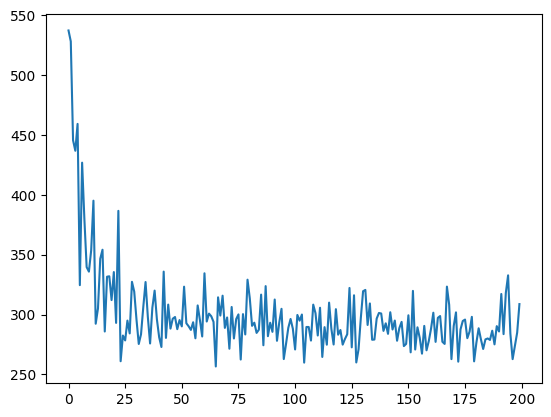

In [74]:
plt.plot(loss_arr)

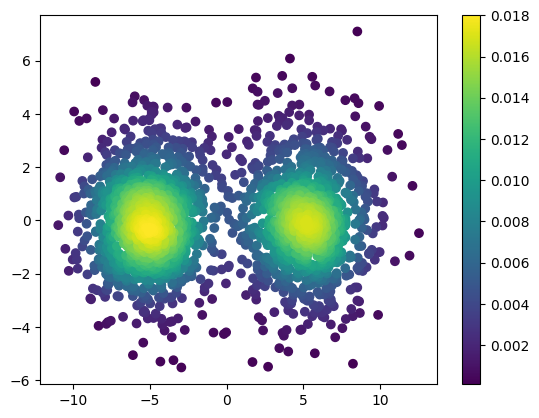

In [75]:
proposal.visualize_dist(2000)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

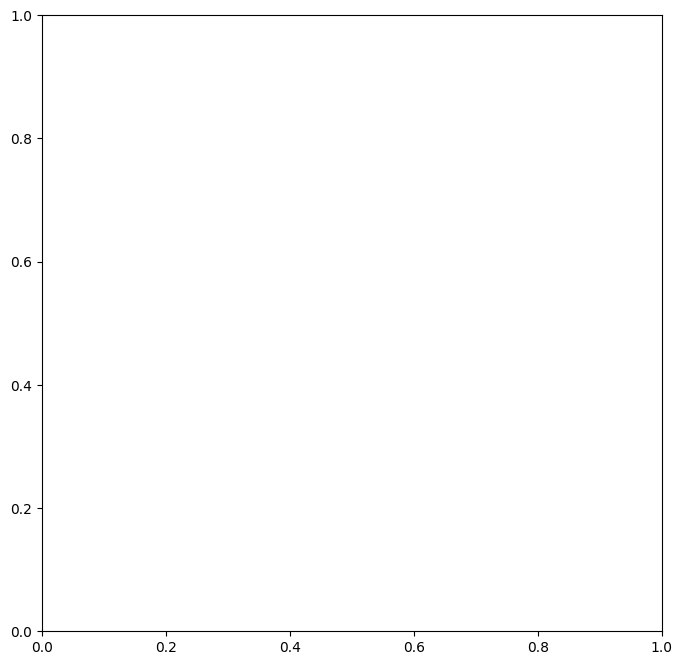

In [79]:
fig, ax = plt.subplots(figsize = (8,8))
proposal.plot_2d_countour(ax=ax)

# TSC implementation

In [60]:
K = 32
torch.manual_seed(0)

latent_size = dim

b = torch.Tensor([1] * (latent_size // 2) + [0] * (latent_size // 2))
num_layers = 32

base = nf.distributions.base.GaussianMixture(n_modes = 2, dim = latent_size)

flows_layers = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows_layers += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows_layers += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows_layers += [nf.flows.ActNorm(latent_size)]

In [68]:
dim = 2

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

N_CHAINS = torch.tensor(50)
N_SAMPLES = 100
BURN_IN = 10
device="cpu"

proposal = GMM(dim=dim, sigma=scale, mu=loc)
target = Banana(dim=dim, b=0.02)

optimizer = optim.Adam(lr=1e-1, params=(loc, scale))

nfm = nf.NormalizingFlow(q0=proposal, flows=flows_layers, p=target)

In [ ]:
n_iter = 200
loss_arr = []

scheduler = StepLR(optimizer, 1, gamma=1-1e-2)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)
    if i%10:
      print(scale, loc)
    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.01,
                  num_leapfrog_steps = 5,
                  verbose = False,
                )

    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])